<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/fluidflow/gaspipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculation of pressure drop in gas pipelines

This notebook is part of [introduction to natural gas processing using NeqSim](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb).

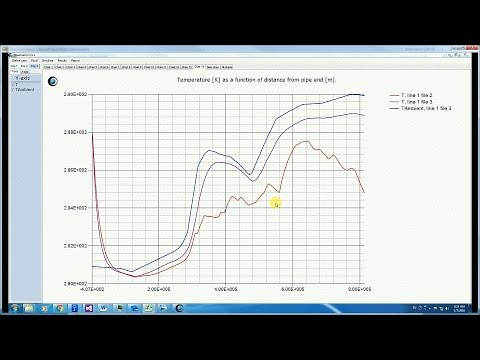

In [12]:
#@title Introduction to Calculation of pressure drop in gas pipelines
#@markdown Calculation of pressure drop in gas pipelines
from IPython.display import YouTubeVideo
YouTubeVideo('C4mq8QlOOsQ', width=600, height=400)

# Initialize use of NeqSim in Python

In [13]:
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('classic')
%matplotlib inline

# Demo of a simple NeqSim gas pipeline simulation

In [18]:
from neqsim import methods
from neqsim.thermo import fluid, TPflash, createfluid2
from neqsim.process import pipe, pipeline, clearProcess, stream, runProcess

#Creating inlet fluid using SRK-EoS
names = ['CO2', 'nitrogen', 'methane', 'ethane']
molefractions = [0.03, 0.02, 0.85, 0.1]
fluid1 = createfluid2(names, molefractions)

#Creating stream and pipeline
clearProcess()
stream1 = stream(fluid1)
stream1.setFlowRate(20.0, "MSm3/day")
stream1.setTemperature(50.15, "C")
stream1.setPressure(160.0, "bara")

diameter = [1.1, 1.1, 1.1, 1.1, 1.1] #meter
roughnes = [50.0e-6, 50.0e-6, 50.0e-6, 50.0e-6, 50.0e-6] #meter
position = [0.0, 500.0, 1000.0, 1200.0, 400000.0] #meter
height = [0.0, -400.0, -800.0, -900.0, 0.0] #meter
outtemperatures =[278.15, 278.15, 278.15, 278.15, 278.15] #Kelvin
outHeatU = [25.0, 25.0, 25.0, 25.0, 25.0] #W/m2K
wallHeatU = [35.0, 35.0, 35.0, 35.0, 35.0] #W/m2K

pipe1 = pipeline(stream1, position, diameter, height, outtemperatures, roughnes,outHeatU,wallHeatU)
pipe1.setNumberOfNodesInLeg(100)
pipe1.setUseConstantFrictionFactor(True)
runProcess()
print('outlet pressure ', pipe1.getPipe().getNode(200).getBulkSystem().getPressure('bara'))
print('outlet temperature ', pipe1.getPipe().getNode(200).getBulkSystem().getTemperature('C'))

outlet pressure  170.3377305538856
outlet temperature  49.83655960315218


In [20]:
print('total number of legs ', pipe1.getPipe().getNumberOfLegs())
print('total number of nodes ', pipe1.getPipe().getTotalNumberOfNodes())
print('friction factor ', pipe1.getPipe().getNode(0).getWallFrictionFactor())
print('friction factor ', pipe1.getPipe().getNode(50).getWallFrictionFactor())

total number of legs  4
total number of nodes  402
friction factor  0.010646527847212619
friction factor  0.010634705176501733


# Graphical output of pressure and temperature profile of pipeline

Text(0.5, 0, 'position [meter]')

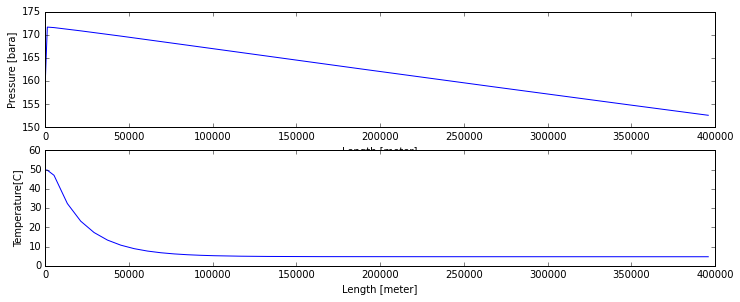

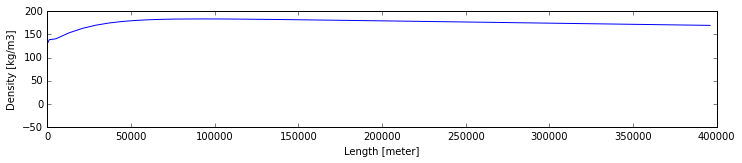

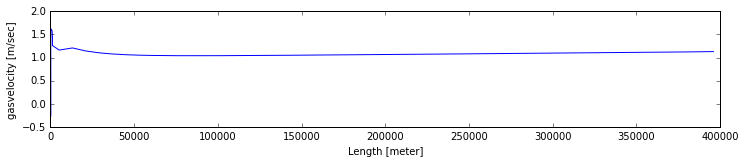

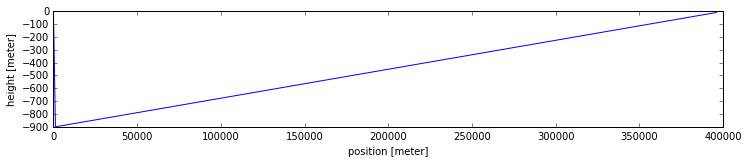

In [16]:
pres = []
temp = []
length = []
height = []
calcdensity = []
gasvelocity = []

for node in range (0,pipe1.getPipe().getTotalNumberOfNodes()-1):
  pres.append(pipe1.getPipe().getNode(node).getBulkSystem().getPressure('bara'))
  temp.append(pipe1.getPipe().getNode(node).getBulkSystem().getTemperature('C'))
  height.append(pipe1.getPipe().getNode(node).getVerticalPositionOfNode())
  length.append(pipe1.getPipe().getNode(node).getDistanceToCenterOfNode())
  calcdensity.append(pipe1.getPipe().getNode(node).getBulkSystem().getDensity('kg/m3'))
  gasvelocity.append(pipe1.getPipe().getNode(node).getVelocity()) 

plt.rcParams['figure.figsize'] = [12, 12]
plt.figure()
plt.subplot(5, 1, 1)
plt.plot(length, pres, '-')
plt.ylabel('Pressure [bara]')
plt.xlabel('Length [meter]')

plt.subplot(5, 1, 2)
plt.plot(length, temp)
plt.xlabel('Length [meter]')
plt.ylabel('Temperature[C]')

plt.figure()
plt.subplot(5, 1, 3)
plt.plot(length, calcdensity, '-')
plt.ylabel('Density [kg/m3]')
plt.xlabel('Length [meter]')

plt.figure()
plt.subplot(5, 1, 4)
plt.plot(length, gasvelocity, '-')
plt.ylabel('gasvelocity [m/sec]')
plt.xlabel('Length [meter]')

plt.figure()
plt.subplot(5, 1, 5)
plt.plot(length, height, '-')
plt.ylabel('height [meter]')
plt.xlabel('position [meter]')

# Pressure drop calculations based on simplified methods
In the follwing section we use simplified methods for calulating pressure drop in gas pipelines.

In [58]:
insideDiameter = 1.0
length = 1.0
R = 8.314
inletPressure = 160.0
frictionFactor = 0.02


stream1 = stream(fluid1)
stream1.setFlowRate(60.0, "MSm3/day")
stream1.setTemperature(20.15, "C")
stream1.setPressure(inletPressure, "bara")
stream1.run()
stream1.getFluid().initProperties()

area = math.pi / 4.0 * math.pow(insideDiameter, 2.0)
velocity = stream1.getFluid().getPhase(0).getTotalVolume() / area / 1.0e5
reynoldsNumber = velocity * insideDiameter/stream1.getFluid().getPhase(0).getPhysicalProperties().getKinematicViscosity()

for i in range(1000):
  dp = math.pow(4.0 * stream1.getFluid().getPhase(0).getNumberOfMolesInPhase()
                        * stream1.getFluid().getPhase(0).getMolarMass()/3.14, 2.0) * frictionFactor * length * stream1.getFluid().getPhase(0).getZ() * R/stream1.getFluid().getPhase(0).getMolarMass() * stream1.getFluid().getTemperature()/math.pow(insideDiameter, 5.0);
  stream1.setPressure(100.0)#stream1.getPressure()-1)
  print('dp ', stream1.getPressure())
  #stream1.run()
  stream1.getFluid().initProperties()
  velocity = stream1.getFluid().getPhase(0).getTotalVolume() / area / 1.0e5
  reynoldsNumber = velocity * insideDiameter/stream1.getFluid().getPhase(0).getPhysicalProperties().getKinematicViscosity()


stream1.getFluid().initProperties()


outletpressure = stream1.getPressure()
print('outlet pressure ',outletpressure)

dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  988599532.0200425
dp  160.0
dp  9885

In [45]:
stream1.getFluid().getPhase(0).getPhysicalProperties().getKinematicViscosity()

1.1953369549016944e-07